In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import (accuracy_score, dcg_score, roc_auc_score, 
                             precision_score, recall_score)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam

from htools import assert_raises, save, load
from incendio.core import *
from incendio.callbacks import *
from incendio.metrics import *
from incendio.optimizers import *
from incendio.utils import *

In [ ]:
# Reproducible testing.
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
class Data(Dataset):
    
    def __init__(self, n=64, dim=2):
        self.x = torch.rand(n, dim).float()
        self.y = torch.clamp(
            (self.x[:, 0]*.75 + self.x[:, 1]*.25).round(), 0, 1
        ).abs().unsqueeze(-1)
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

In [ ]:
class MulticlassData(Dataset):
    
    def __init__(self, n=64, dim=2):
        self.x = torch.rand(n, dim).float()
        # Integer labels between 0 and 4, inclusive.
        self.y = torch.clamp(
            torch.round(
                torch.randint(6, (n, 1)).float() 
                * (self.x[:, 0]*.75 + self.x[:, 1]*.25).unsqueeze(-1)
            ), 0, 4).long().flatten()
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

In [ ]:
ypred_ = torch.rand(5, 2)
y_ = torch.tensor([0, 1, 1, 0, 1])
ypred_, y_

(tensor([[0.4963, 0.7682],
         [0.0885, 0.1320],
         [0.3074, 0.6341],
         [0.4901, 0.8964],
         [0.4556, 0.6323]]), tensor([0, 1, 1, 0, 1]))

In [ ]:
class SimpleModel(BaseModel):
    
    def __init__(self, dim):
        super().__init__()  
        self.fc1 = nn.Linear(dim, 2)
        self.fc2 = nn.Linear(2, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
class GroupedModel(BaseModel):
    
    def __init__(self, dim):
        super().__init__()  
        g1 = nn.Sequential(
            nn.Linear(dim, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 4),
            nn.LeakyReLU()
        )
        g2 = nn.Linear(4, 1)
        self.groups = nn.ModuleList([g1, g2])
        
    def forward(self, x):
        for group in self.groups:
            x = group(x)
        return x

In [ ]:
DIM = 2

In [ ]:
snet = SimpleModel(DIM)
snet

SimpleModel(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)

In [ ]:
optim = variable_lr_optimizer(snet, 2e-3)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.002
    weight_decay: 0
)

In [ ]:
with assert_raises(ValueError) as ar:
    optim = variable_lr_optimizer(snet, [3e-3, 1e-1])
    optim

As expected, got ValueError(Received more learning rates than layer groups.).


In [ ]:
update_optimizer(optim, 1e-3, 0.5)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0
)

In [ ]:
snet.freeze()
for n in range(5):
    snet.unfreeze(n_layers=n)
    print(n, snet.trainable())

0 [((2, 2), False), ((2,), False), ((1, 2), False), ((1,), False)]
1 [((2, 2), False), ((2,), False), ((1, 2), False), ((1,), True)]
2 [((2, 2), False), ((2,), False), ((1, 2), True), ((1,), True)]
3 [((2, 2), False), ((2,), True), ((1, 2), True), ((1,), True)]
4 [((2, 2), True), ((2,), True), ((1, 2), True), ((1,), True)]


In [ ]:
snet.freeze()
with assert_raises(AttributeError) as ar:
    for n in range(3):
        snet.unfreeze(n_groups=n)
        print(n, snet.trainable())

As expected, got AttributeError('SimpleModel' object has no attribute 'groups').


# Training

In [ ]:
DIM = 2
metrics = [accuracy_score, 
           precision_score, 
           recall_score, 
           percent_positive,
           mean_soft_prediction
          ]

# Model starts out unfrozen and freezes last group startingn with epoch 3.
# This is not useful but is done here for testing purposes.
callbacks = [EarlyStopper('max', 'accuracy', patience=3),
             PerformanceThreshold('recall', 'max', 0.25, skip_epochs=5),
             MetricHistory(),
             ModelUnfreezer({3:1}, 'groups'),
             ModelCheckpoint(),
             CosineLRScheduler(),
             S3Uploader('gg-datascience', 'hmamin/incendio/v1')
            ]

In [ ]:
train = Data(n=300, dim=DIM)
val = Data(n=30, dim=DIM)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [ ]:
gnet = GroupedModel(DIM)
t = Trainer(gnet, train, val, dl_train, dl_val, F.binary_cross_entropy_with_logits, 
            'binary', '../data/v1', torch.optim.RMSprop, 
            last_act=torch.sigmoid, metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v1')

Datasets: 300 train rows, 30 val rows

Optimizer: None

GroupedModel(
  (groups): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
))

In [ ]:
t.save('tmp.pkl')

Data written to ../data/v1/tmp.pkl.


In [ ]:
t.load('tmp.pkl')

Object loaded from ../data/v1/tmp.pkl.

2020-02-18 17:06:42,841
 Could not load optimizer.  Loading model weights only.


In [ ]:
d = load('../data/v1/tmp.pkl')

Object loaded from ../data/v1/tmp.pkl.


2020-02-18 17:05:55,471 [INFO]: Removing files from output directory.




2020-02-18 17:05:55,642
 
=====

Epoch 0

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.7622 |       0.7841 |
| accuracy             |  0.5200 |       0.5667 |
| precision            |  0.2786 |       0.5667 |
| recall               |  0.4689 |       1.0000 |
| percent_positive     |  0.4500 |       1.0000 |
| mean_soft_prediction |  0.4903 |       0.7714 |

=====

2020-02-18 17:05:55,643
 Saving model. Loss improved from inf to 0.7841.
Data written to ../data/v1/trainer.pkl.


/Users/harrisonmamin/.pyenv/versions/3.7.4/envs/main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




2020-02-18 17:05:55,786
 
=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.7072 |       0.7335 |
| accuracy             |  0.5200 |       0.4333 |
| precision            |  0.3200 |       0.0000 |
| recall               |  0.5778 |       0.0000 |
| percent_positive     |  0.5767 |       0.0000 |
| mean_soft_prediction |  0.5299 |       0.3847 |

=====

2020-02-18 17:05:55,787
 Saving model. Loss improved from 0.7841 to 0.7335.
Data written to ../data/v1/trainer.pkl.


/Users/harrisonmamin/.pyenv/versions/3.7.4/envs/main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




2020-02-18 17:05:55,920
 
=====

Epoch 2

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.5200 |       0.3595 |
| accuracy             |  0.7800 |       0.8333 |
| precision            |  0.6821 |       0.7711 |
| recall               |  0.7364 |       1.0000 |
| percent_positive     |  0.4900 |       0.7333 |
| mean_soft_prediction |  0.5552 |       0.7156 |

=====

2020-02-18 17:05:55,921
 Saving model. Loss improved from 0.7335 to 0.3595.
Data written to ../data/v1/trainer.pkl.

2020-02-18 17:05:55,922
 Training complete. Model in eval mode.


  0%|          | 0/5 [00:00<?, ?it/s]

File: ../data/v1/train.log
Bucket: gg-datascience
Key: hmamin/incendio/v1/train.log
File: ../data/v1/history.csv
Bucket: gg-datascience
Key: hmamin/incendio/v1/history.csv
File: ../data/v1/trainer.pkl
Bucket: gg-datascience
Key: hmamin/incendio/v1/trainer.pkl
File: ../data/v1/lrs.png
Bucket: gg-datascience
Key: hmamin/incendio/v1/lrs.png
File: ../data/v1/history.png
Bucket: gg-datascience
Key: hmamin/incendio/v1/history.png


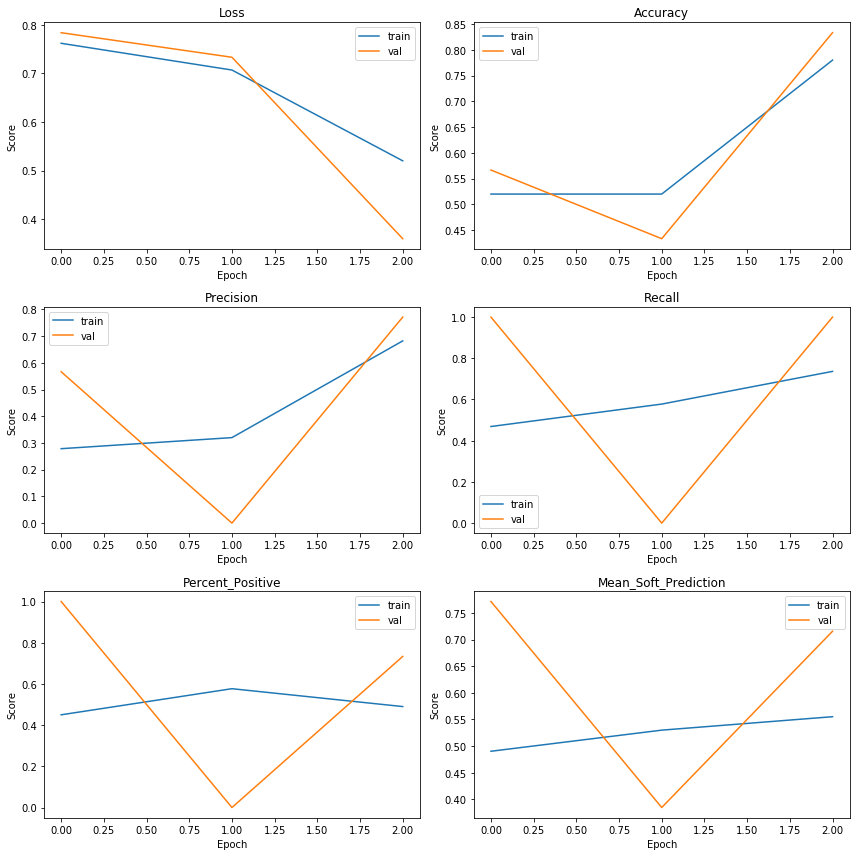

In [ ]:
t.fit(3, 3e-1, 0.5, clean=True)

In [ ]:
t.save('trainer.zip')

Data written to ../data/v1/trainer.zip.


In [ ]:
t2 = Trainer.from_file(os.path.join('..', 'data', 'v1', 'trainer.zip'))
print(t2)
del t2; gc.collect()

Object loaded from ../data/v1/trainer.zip.
Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v1')

Datasets: 300 train rows, 30 val rows

Optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.015052040053751204
    momentum: 0
    weight_decay: 0

Parameter Group 1
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.030104080107502408
    momentum: 0
    weight_decay: 0
)

GroupedModel(
  (groups): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
))


19995

## Multiclass classification

In [ ]:
class SimpleMulticlassModel(BaseModel):
    
    def __init__(self, dim, classes):
        super().__init__()  
        self.fc1 = nn.Linear(dim, 10)
        self.fc2 = nn.Linear(10, classes)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
DIM = 2
metrics = [accuracy_score,
           mean_soft_prediction
          ]

# Model starts out unfrozen and freezes last group startingn with epoch 3.
# This is not useful but is done here for testing purposes.
callbacks = [EarlyStopper('max', 'accuracy', patience=3),
             PerformanceThreshold('loss', 'min', 2, skip_epochs=5),
             MetricHistory(),
             ModelUnfreezer({3:2}, 'layers'),
             ModelCheckpoint(),
             MetricHistory(),
             CosineLRScheduler(),
             S3Uploader('gg-datascience', 'hmamin/incendio/v2')
            ]

In [ ]:
train = MulticlassData(n=34, dim=DIM)
val = MulticlassData(n=30, dim=DIM)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [ ]:
next(iter(dl_train))

[tensor([[0.2199, 0.8899],
         [0.5928, 0.9209],
         [0.1033, 0.7044],
         [0.7221, 0.8767],
         [0.9785, 0.8563],
         [0.1482, 0.4460],
         [0.1631, 0.2388],
         [0.3072, 0.0535]]), tensor([1, 1, 1, 3, 4, 1, 1, 1])]

In [ ]:
smnet = SimpleMulticlassModel(DIM, 5)
t = Trainer(smnet, train, val, dl_train, dl_val, 
            F.cross_entropy, 'multiclass', '../data/v1', torch.optim.RMSprop, 
            last_act=F.softmax, metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='cross_entropy', out_dir='../data/v1')

Datasets: 34 train rows, 30 val rows

Optimizer: None

SimpleMulticlassModel(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
))



2020-02-18 15:57:20,486
 
=====

Epoch 0

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.5430 |       1.7918 |
| accuracy             |  0.2647 |       0.3667 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-18 15:57:20,487
 Saving model. Loss improved from inf to 1.7918.
Data written to ../data/v1/trainer.pkl.




2020-02-18 15:57:20,525
 
=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3794 |       1.4423 |
| accuracy             |  0.5000 |       0.3667 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-18 15:57:20,526
 Saving model. Loss improved from 1.7918 to 1.4423.
Data written to ../data/v1/trainer.pkl.




2020-02-18 15:57:20,561
 
=====

Epoch 2

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2873 |       1.4404 |
| accuracy             |  0.4706 |       0.3333 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-18 15:57:20,562
 Saving model. Loss improved from 1.4423 to 1.4404.
Data written to ../data/v1/trainer.pkl.

2020-02-18 15:57:20,564
 Epoch 3: Unfreezing last 2 layers.




2020-02-18 15:57:20,596
 
=====

Epoch 3

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2710 |       1.4384 |
| accuracy             |  0.4706 |       0.3333 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-18 15:57:20,597
 Saving model. Loss improved from 1.4404 to 1.4384.
Data written to ../data/v1/trainer.pkl.




2020-02-18 15:57:20,628
 
=====

Epoch 4

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2655 |       1.4421 |
| accuracy             |  0.4706 |       0.3667 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-18 15:57:20,629
 EarlyStopper halting training: validation accuracy has not improved enough in 4 epochs.

2020-02-18 15:57:20,630
 Training complete. Model in eval mode.


  0%|          | 0/6 [00:00<?, ?it/s]

File: ../data/v1/train.log
Bucket: gg-datascience
Key: hmamin/incendio/v2/train.log
File: ../data/v1/history.csv
Bucket: gg-datascience
Key: hmamin/incendio/v2/history.csv
File: ../data/v1/trainer.pkl
Bucket: gg-datascience
Key: hmamin/incendio/v2/trainer.pkl
File: ../data/v1/trainer.zip
Bucket: gg-datascience
Key: hmamin/incendio/v2/trainer.zip
File: ../data/v1/lrs.png
Bucket: gg-datascience
Key: hmamin/incendio/v2/lrs.png


  0%|          | 0/6 [00:00<?, ?it/s]

File: ../data/v1/history.png
Bucket: gg-datascience
Key: hmamin/incendio/v2/history.png


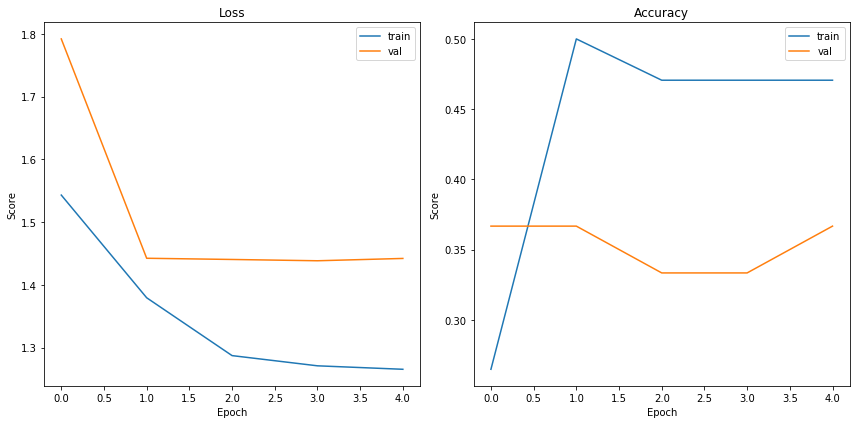

In [ ]:
t.fit(10, 3e-3)

### Scratch

In [ ]:
*x, y = next(iter(dl_train))
x, y

In [ ]:
yhat = smnet(*x)
yhat

In [ ]:
y.shape, yhat.shape

In [ ]:
F.softmax(yhat, dim=-1)

In [ ]:
yhat.shape, y.shape

In [ ]:
F.cross_entropy(yhat, y)

In [ ]:
t = Trainer(smnet, train, val, dl_train, dl_val, F.cross_entropy, 'multiclass',
        '../data/v2', 'datascience-delphi-dev', last_act=partial(F.softmax, dim=-1),
            metrics=metrics, callbacks=callbacks)
t